# Preamble

In [1]:
%load_ext autoreload

In [2]:
import os
os.chdir('..')
os.path.realpath(os.path.curdir)

'/Users/byronsmith/Projects/strain-corr'

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from lib.pandas_util import idxwhere, align_indexes, invert_mapping
import matplotlib as mpl
import lib.plot
import statsmodels as sm
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm
import subprocess
from tempfile import mkstemp
import time
import subprocess

In [4]:
import sfacts as sf

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
sns.set_context('talk')
plt.rcParams['figure.dpi'] = 100
stemA = 'hmp2.a.r.proc'
centroid = 75
stemB = 'filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts26-s75-seed0'

# Analysis Parameters

In [6]:
species_id = '102506'
# depth_ratio_bound = 3
# species_gene_corr_thresh = 0.99
# n_species_genes = 2000
species_gene_corr_thresh = 0.98

# Prepare Data

## Taxonomy

In [7]:
species_taxonomy = pd.read_table('ref/gtpro/species_taxonomy_ext.tsv', names=['genome_id', 'species_id', 'taxonomy_string']).assign(species_id=lambda x: x.species_id.astype(str)).set_index('species_id')[['taxonomy_string']].assign(taxonomy_split=lambda x: x.taxonomy_string.str.split(';'))

for level_name, level_number in [('p__', 1), ('c__', 2), ('o__', 3), ('f__', 4), ('g__', 5), ('s__', 6)]:
    species_taxonomy = species_taxonomy.assign(**{level_name: species_taxonomy.taxonomy_split.apply(lambda x: x[level_number])}) 
species_taxonomy = species_taxonomy.drop(columns=['taxonomy_split'])

species_taxonomy.loc[species_id]

taxonomy_string    d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
p__                                                p__Proteobacteria
c__                                           c__Gammaproteobacteria
o__                                              o__Enterobacterales
f__                                            f__Enterobacteriaceae
g__                                                   g__Escherichia
s__                                                              s__
Name: 102506, dtype: object

## Species

In [8]:
all_species_depth = pd.read_table(f'data/{stemA}.gtpro.species_depth.tsv', index_col=['sample', 'species_id']).squeeze().unstack('species_id', fill_value=0).rename(str, axis='columns')
species_rabund = all_species_depth.divide(all_species_depth.sum(1), axis=0)

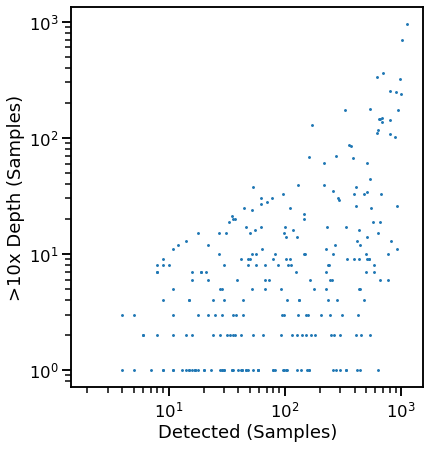

In [9]:
x = (all_species_depth > 0.05).sum(0)
y = (all_species_depth > 10).sum(0)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x, y, s=2)
# ax.plot([0, 1e4], [0, 1e4], c='k', lw=2, linestyle=':')
# ax.plot([0, 5e3], [0, 5e3], c='k', lw=1, linestyle=':')

# plt.plot([0, 1], [0, 0.1], c='k')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('>10x Depth (Samples)')
ax.set_xlabel('Detected (Samples)')

# ax.set_ylim(1, 3e3)
# ax.set_xlim(1, 3e3)
ax.set_aspect(1)

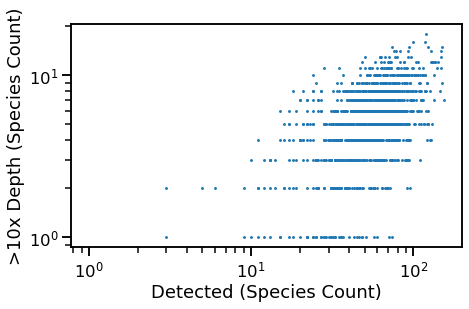

In [10]:
x = (all_species_depth > 0.05).sum(1)
y = (all_species_depth > 10).sum(1)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x, y, s=2)
# ax.plot([0, 1e4], [0, 1e4], c='k', lw=2, linestyle=':')
# ax.plot([0, 5e3], [0, 5e3], c='k', lw=1, linestyle=':')

# plt.plot([0, 1], [0, 0.1], c='k')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('>10x Depth (Species Count)')
ax.set_xlabel('Detected (Species Count)')

# ax.set_ylim(1, 3e3)
# ax.set_xlim(1, 3e3)
ax.set_aspect(1)

In [11]:
(all_species_depth > 1.0).sum(1)

sample
CSM5FZ4M_G110153    18
CSM5MCUO_G110157    42
CSM5MCVL_G110038    14
CSM5MCVN_G110144    11
CSM5MCW6_G110147    15
                    ..
PSMB4MBS_G110702    32
PSMB4MC1_G111932    31
PSMB4MC3_G111934    19
PSMB4MC5_G110704    18
PSMB4MC7_G110703    20
Length: 1325, dtype: int64

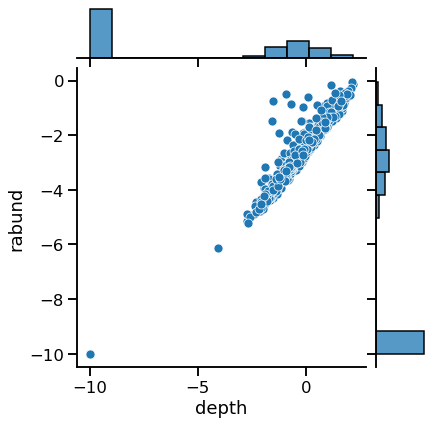

In [12]:
d = pd.DataFrame(dict(depth=np.log10(all_species_depth[species_id] + 1e-10), rabund=np.log10(species_rabund[species_id] + 1e-10)))

sns.jointplot(x='depth', y='rabund', data=d)

In [13]:
gtpro_species_depth = pd.read_table(f'data/sp-{species_id}.{stemA}.gtpro.species_depth.tsv', dtype=dict(sample=str, species_id=str, depth=float), index_col=['sample', 'species_id']).squeeze().unstack('species_id')

In [14]:
species_depth = pd.read_table(f'data_temp/sp-{species_id}.{stemA}.midas_gene{centroid}.species_depth.tsv', names=['sample', 'depth'], index_col='sample').squeeze()

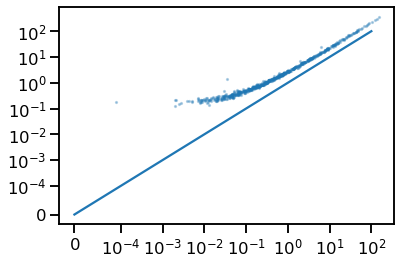

In [15]:
d = pd.DataFrame(dict(gtpro=gtpro_species_depth[species_id], midas=species_depth))

plt.scatter('gtpro', 'midas', data=d, s=3, alpha=0.3)
plt.plot([0, 1e2], [0, 1e2])
plt.yscale('symlog', linthresh=1e-4)
plt.xscale('symlog', linthresh=1e-4)

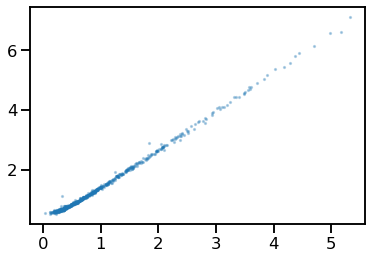

In [16]:
d = pd.DataFrame(dict(gtpro=gtpro_species_depth[species_id], midas=species_depth))

plt.scatter('gtpro', 'midas', data=np.cbrt(d), s=3, alpha=0.3)
# plt.plot([0, 1e2], [0, 1e2])
# plt.yscale('symlog', linthresh=1e-4)
# plt.xscale('symlog', linthresh=1e-4)

In [17]:
species_corr = pd.read_table(f'data_temp/sp-{species_id}.{stemA}.midas_gene{centroid}.species_correlation.tsv', names=['sample', 'correlation'], index_col='sample').squeeze()

## Metadata

In [18]:
mgen = pd.read_table('meta/hmp2/mgen.tsv', index_col='library_id')
preparation = pd.read_table('meta/hmp2/preparation.tsv', index_col='preparation_id')
stool = pd.read_table('meta/hmp2/stool.tsv', index_col='stool_id')

sample_meta = mgen.join(preparation, on='preparation_id', rsuffix='_').join(stool, on='stool_id').loc[all_species_depth.index]

In [19]:
len(sample_meta.stool_id.unique()), len(sample_meta.subject_id.unique())

(1305, 106)

## Strains

In [20]:
fit = sf.World.load(
    f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.world.nc'
).drop_low_abundance_strains(0.05)
print(fit.sizes)

np.random.seed(0)
fit_ss = fit.random_sample(position=min(fit.sizes['position'], 500))

Frozen({'strain': 110, 'position': 10000, 'sample': 624, 'allele': 2})


In [21]:
strain_corr = pd.read_table(
    f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_correlation.tsv',
    index_col=['gene_id', 'strain']
).squeeze().unstack(fill_value=0)
# strain_corr = strain_by_species_corr.sel(species_id=species_id).to_series().unstack('strain')
strain_depth = pd.read_table(
    f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_depth_ratio.tsv',
    index_col=['gene_id', 'strain']
).squeeze().unstack()
strain_corr, strain_depth = align_indexes(*align_indexes(strain_corr, strain_depth), axis="columns")

In [22]:
sample_to_strain = (
    (fit.community.data > 0.95)
    .to_series()
    .unstack()
    .apply(idxwhere, axis=1)
    [lambda x: x.apply(bool)]
    .str[0]
    .rename('strain')
)
    
strain_to_sample_list = (
    sample_to_strain
    .rename('strain_id')
    .reset_index()
    .groupby('strain_id')
    .apply(lambda x: x['sample'].to_list())
)
strain_to_sample_list.apply(len).sort_values(ascending=False).head()

strain_id
2     99
1     20
14    16
31    12
11    11
dtype: int64

In [23]:
# species_gene_corr_thresh = species_corr.sort_values(ascending=False).head(n_species_genes + 1).min()
species_gene_list = idxwhere(species_corr.loc[strain_corr.index] > species_gene_corr_thresh)
print(len(species_gene_list))

2407


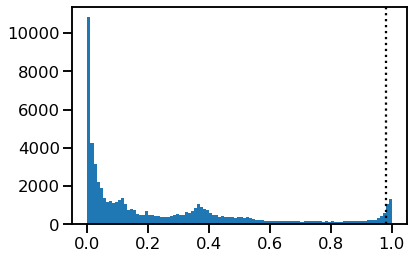

In [24]:
# strain_thresh = pd.read_table(
#     f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_correlation_threshold.tsv',
#     names=['strain_id', 'threshold'],
#     index_col='strain_id',
# ).loc[strain_corr.columns]
plt.hist(species_corr, bins=np.linspace(0, 1, num=101))
plt.axvline(species_gene_corr_thresh, linestyle=':', color='k')

In [25]:
strain_frac = pd.read_table(f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.comm.tsv', index_col=['sample', 'strain']).squeeze().unstack(fill_value=0)

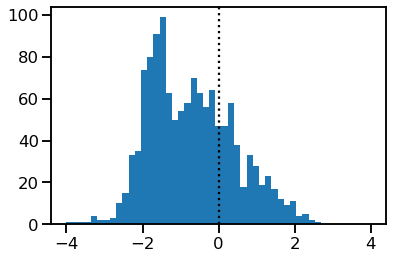

In [26]:
plt.hist(np.log10(species_depth[species_depth > 0]), bins=np.linspace(-4, 4))
plt.axvline(np.log10(1.0), linestyle=':', color='k')

In [27]:
mgen.sequenced_reads.quantile([0.25, 0.5, 0.75])

0.25    12562372.75
0.50    15989118.50
0.75    19527682.25
Name: sequenced_reads, dtype: float64

## MIDAS Genes, COGs COG categories

In [28]:
gene_cluster = pd.read_table(
    f'ref_temp/midasdb_uhgg/pangenomes/{species_id}/cluster_info.txt'
).set_index('centroid_99', drop=False).rename_axis(index='gene_id')
gene_annotation = pd.read_table(
    f'ref_temp/midasdb_uhgg.sp-{species_id}.gene{centroid}_annotations.tsv',
    names=['locus_tag', 'ftype', 'length_bp', 'gene', 'EC_number', 'COG', 'product'],
    index_col='locus_tag',
).rename(columns=str.lower)

gene_meta = gene_cluster.loc[gene_cluster[f'centroid_{centroid}'].unique()].join(gene_annotation)

In [29]:
_cog_meta = pd.read_table(
    'ref/cog-20.meta.tsv',
    names=['cog', 'categories', 'description', 'gene', 'pathway', '_1', '_2'],
    index_col=['cog']
)
cog_meta = _cog_meta.drop(columns=['categories', '_1', '_2'])
cog_x_category = _cog_meta.categories.apply(tuple).apply(pd.Series).unstack().to_frame(name='category').reset_index()[['cog', 'category']].dropna()

In [30]:
cog_category = pd.read_table('ref/cog-20.categories.tsv', names=['category', 'description'], index_col='category')

## Genes

In [31]:
sample_depth = xr.load_dataarray(f'data_temp/sp-{species_id}.{stemA}.midas_gene{centroid}.depth.nc')

## References

In [32]:
reference_meta = pd.read_table('ref_temp/uhgg_genomes_all_4644.tsv', index_col='Genome').rename_axis(index='genome_id')[lambda x: x.MGnify_accession == 'MGYG-HGUT-' + species_id[1:]].rename(lambda s: 'UHGG' + s[10:])
reference_meta.head()

Genome_type   Length  N_contigs     N50  GC_content  Completeness  \
genome_id                                                                      
UHGG000026     Isolate  5095388         44  245104       50.56         99.72   
UHGG000027     Isolate  4998207        106  103519       50.65         99.03   
UHGG000036     Isolate  4978086        124   99332       50.65         99.27   
UHGG000309     Isolate  4682102         42  653581       50.65         99.97   
UHGG000316     Isolate  5046484         66  244235       50.51         99.67   

            Contamination       Species_rep MGnify_accession  \
genome_id                                                      
UHGG000026           0.08  GUT_GENOME144544  MGYG-HGUT-02506   
UHGG000027           0.30  GUT_GENOME144544  MGYG-HGUT-02506   
UHGG000036           0.35  GUT_GENOME144544  MGYG-HGUT-02506   
UHGG000309           0.93  GUT_GENOME144544  MGYG-HGUT-02506   
UHGG000316           0.04  GUT_GENOME144544  MGYG-HGUT-02506   

                                                      Lineage      Continent  
genome_id                                                                     
UHGG000026  d__Bacteria;p__Proteobacteria;c__Gammaproteoba...         Europe  
UHGG000027  d__Bacteria;p__Proteobacteria;c__Gammaproteoba...         Europe  
UHGG000036  d__Bacteria;p__Proteobacteria;c__Gammaproteoba...         Europe  
UHGG000309  d__Bacteria;p__Proteobacteria;c__Gammaproteoba...  North America  
UHGG000316  d__Bacteria;p__Proteobacteria;c__Gammaproteoba...         Europe

In [33]:
reference_gene = xr.load_dataarray(f'data_temp/sp-{species_id}.midas_gene{centroid}.reference_copy_number.nc')
reference_gene = pd.DataFrame(reference_gene.T.values, index=reference_gene.gene_id, columns=reference_gene.genome_id)

In [34]:
isolate_gene = reference_gene[idxwhere(reference_meta.Genome_type == 'Isolate')]

# QC Strains

In [35]:
strain_depth_thresh_high = strain_depth.loc[species_gene_list].quantile(0.99)
strain_depth_thresh_low = strain_depth.loc[species_gene_list].quantile(0.01)

In [36]:
strain_thresholds = (
    pd.read_table(f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_gene_threshold.tsv', index_col='strain')
    .rename(columns=dict(
        correlation='corr_threshold',
        depth_high='depth_thresh_high',
        depth_low='depth_thresh_low',
    ))
)

In [37]:
_strain_meta = (
    strain_thresholds
    .join(fit.genotype.entropy().to_series().rename('genotype_entropy'))
    .join(fit.metagenotype.entropy().to_series().rename('metagenotype_entropy').groupby(sample_to_strain).mean().rename(int))
    .join(strain_to_sample_list.apply(len).rename('num_samples'))
    .join(species_depth.apply(np.cbrt).groupby(sample_to_strain).std().rename('depth_stdev').rename(int))
    .join(species_depth.apply(np.cbrt).groupby(sample_to_strain).max().rename('depth_max').rename(int))
    .join(species_depth.apply(np.cbrt).groupby(sample_to_strain).sum().rename('depth_sum').rename(int))
    .assign(power_index=lambda x: x.depth_stdev * np.sqrt(x.num_samples))
)
strain_meta = _strain_meta[lambda x: (x.corr_threshold > 0.3)]
    
strain_meta.sort_values('num_samples', ascending=False)

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


corr_threshold  depth_thresh_low  depth_thresh_high  genotype_entropy  \
strain                                                                          
2             0.876283          0.237063           2.165007          0.053481   
1             0.769989          0.209361           2.383190          0.162809   
14            0.908965          0.226282           2.249877          0.133601   
31            0.786100          0.179615           2.393943          0.111861   
11            0.983793          0.256457           2.461352          0.049607   
13            0.818479          0.181206           2.434600          0.119951   
6             0.902774          0.215266           2.289883          0.159513   
5             0.840617          0.195192           2.494984          0.125092   
24            0.914654          0.158011           2.394753          0.114470   
28            0.958034          0.229846           2.088094          0.068996   
32            0.802960          0.166602           2.509907          0.114647   
4             0.917223          0.219031           2.242662          0.114657   
41            0.887553          0.200379           2.155110          0.093459   
25            0.949802          0.242540           2.053767          0.052893   
17            0.821263          0.177036           2.290031          0.138536   
43            0.954394          0.261872           2.286480          0.304354   
30            0.802343          0.213019           2.385313          0.116962   
15            0.863435          0.178124           2.113331          0.129409   
34            0.806837          0.183154           2.191803          0.141928   
47            0.773194          0.167629           2.247098          0.148158   
20            0.716176          0.130498           2.473039          0.112671   
22            0.889168          0.220472           2.126738          0.169557   
10            0.770968          0.124146           2.271455          0.113506   
8             0.672357          0.132635           2.259110          0.145026   
50            0.718363          0.170770           2.282244          0.134092   

        metagenotype_entropy  num_samples  depth_stdev  depth_max   depth_sum  \
strain                                                                          
2                   0.002659           99     0.945697   5.898217  125.579142   
1                   0.002950           20     0.483224   2.451602   24.834750   
14                  0.010753           16     1.312722   5.799218   23.476299   
31                  0.001198           12     0.597524   2.401835   14.548426   
11                  0.001486           11     1.265402   7.119434   42.458982   
13                  0.010447           10     0.546210   2.250560   13.783452   
6                   0.017053            9     0.826998   2.831254   16.182600   
5                   0.014974            8     0.514443   2.179431   12.654722   
24                  0.036347            7     0.739462   3.569103   16.606832   
28                  0.001964            6     0.854029   4.653019   19.959178   
32                  0.015361            5     0.692335   2.349525    7.432653   
4                   0.041987            5     1.295113   4.066254   11.364067   
41                  0.008170            4     1.793003   4.542866    7.464224   
25                  0.000780            4     2.356994   6.624767   12.504772   
17                  0.046516            3     1.202485   3.160628    5.404100   
43                  0.310346            2     1.108146   6.151932   10.736709   
30                  0.017915            2     0.473359   2.610766    4.552101   
15                  0.056882            2     0.200693   3.121584    5.959344   
34                  0.166278            1          NaN   3.358651    3.358651   
47                  0.099780            1          NaN   3.023555    3.023555   
20                  0.077750          

(-3.0, 3.0)

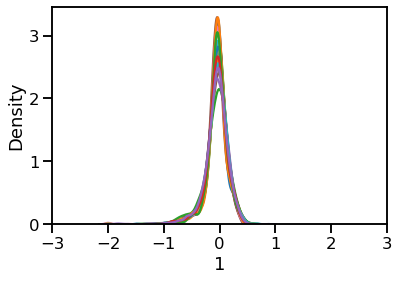

In [38]:
pseudo = 1e-2

for strain in strain_meta.index:
    sns.kdeplot(np.log10(strain_depth.loc[species_gene_list][strain] + pseudo), label=strain)

plt.xlim(-3, 3)

(-3.0, 3.0)

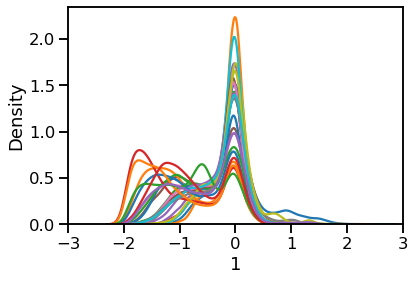

In [39]:
pseudo = 1e-2

for strain in strain_meta.index:
    sns.kdeplot(np.log10(strain_depth[strain_corr[strain_meta.index] > strain_meta.corr_threshold][strain] + pseudo), label=strain)

plt.xlim(-3, 3)

/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_7568/459357348.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = np.log10(strain_depth[species_corr > 0.95].quantile(qq)[strain])
/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


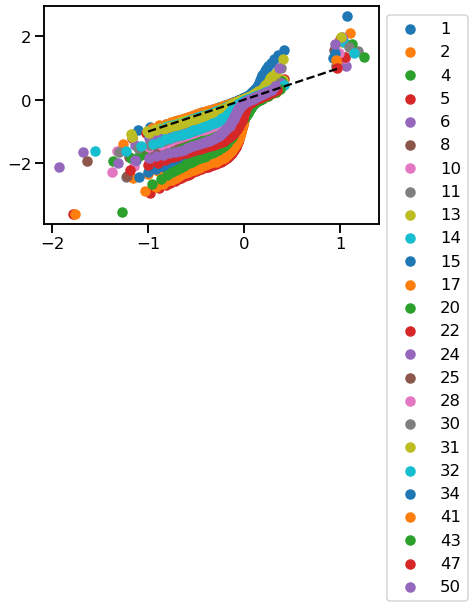

In [40]:
for strain in strain_meta.index:
    qq = np.linspace(0, 1, num=100)
    x = np.log10(strain_depth[species_corr > 0.95].quantile(qq)[strain])
    y = np.log10(strain_depth[strain_corr[strain_meta.index] > strain_meta.corr_threshold].quantile(qq)[strain])
    plt.scatter(x, y, label=strain)

plt.plot([-1, 1], [-1, 1], linestyle='--', color='k')
plt.legend(bbox_to_anchor=(1, 1))

# Enrichment Analysis

In [41]:
corr_hit = strain_corr[strain_meta.index] > strain_meta.corr_threshold
# fixed_corr_hit = strain_corr > 0.9
low_corr =  strain_corr[strain_meta.index] < 0.3
corr_medium_hit = (1 - strain_corr[strain_meta.index]) < (2 * (1 - strain_meta.corr_threshold))
# strict_depth_hit = (strain_depth < (depth_ratio_bound / 2)) & (strain_depth > 1 / (2 * depth_ratio_bound))
depth_hit = (strain_depth[strain_meta.index] < strain_meta.depth_thresh_high) & (strain_depth[strain_meta.index] > strain_meta.depth_thresh_low)
low_depth = (strain_depth[strain_meta.index] < strain_meta.depth_thresh_low)
high_depth = (strain_depth[strain_meta.index] > strain_meta.depth_thresh_high)
high_confidence_hit = depth_hit & corr_hit
# highest_confidence_hit = depth_hit & corr_hit & ~decoy_hit

# fixed_corr_depth_filtered_hit = depth_hit & fixed_corr_hit
# medium_confidence_hit = depth_hit & corr_medium_hit

ambiguous_hit = depth_hit ^ corr_hit
high_confidence_not_hit = low_depth & low_corr
# fixed_corr_not_hit = low_depth & low_corr
high_depth_hit = corr_hit & high_depth

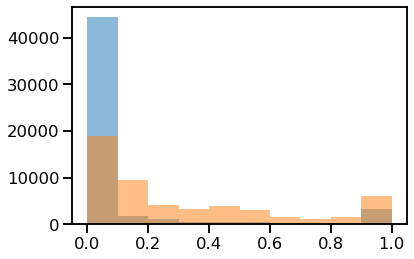

In [42]:
bins = np.linspace(0, 1, num=11)

plt.hist(high_confidence_hit.mean(1), bins=bins, alpha=0.5)
# plt.hist(medium_confidence_hit.mean(1), bins=bins, alpha=0.5)
plt.hist(1 - high_confidence_not_hit.mean(1), bins=bins, alpha=0.5)
# plt.hist(highest_confidence_hit.mean(1), bins=bins, alpha=0.5)

# plt.yscale('log')

None

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


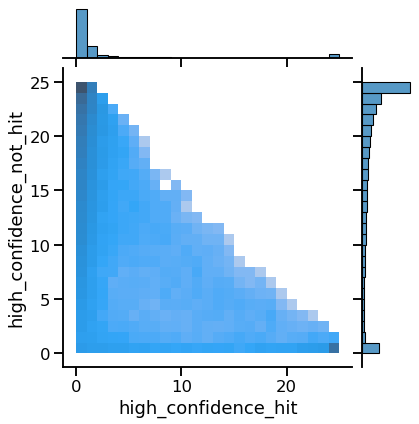

In [43]:
d = pd.DataFrame(dict(high_confidence_hit=high_confidence_hit.sum(1),
                      high_confidence_not_hit=high_confidence_not_hit.sum(1)
                     ))
_max = high_confidence_hit.shape[1]

sns.jointplot(
    'high_confidence_hit',
    'high_confidence_not_hit',
    data=d,
    kind='hist',
    bins=(_max, _max),
    norm=mpl.colors.PowerNorm(1/5),
    vmin=None,
    vmax=None,
)

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


3437 2170

tRNA modification                           32
TCA cycle                                   17
Ribosome 50S subunit                        17
Aminoacyl-tRNA synthetases                  14
Fatty acid biosynthesis                     13
Isoleucine, leucine, valine biosynthesis    13
Aromatic amino acid biosynthesis            12
23S rRNA modification                       12
Menaquinone biosynthesis                    12
Heme biosynthesis                           12
Name: pathway, dtype: int64

hypothetical protein                           1267
Vitamin B12 import ATP-binding protein BtuD      25
putative protein                                  7
HTH-type transcriptional regulator HdfR           5
HTH-type transcriptional activator RhaS           5
L-threonine 3-dehydrogenase                       5
HTH-type transcriptional repressor NanR           5
Glucitol operon repressor                         4
Sialic acid transporter NanT                      4
Putrescine transporter

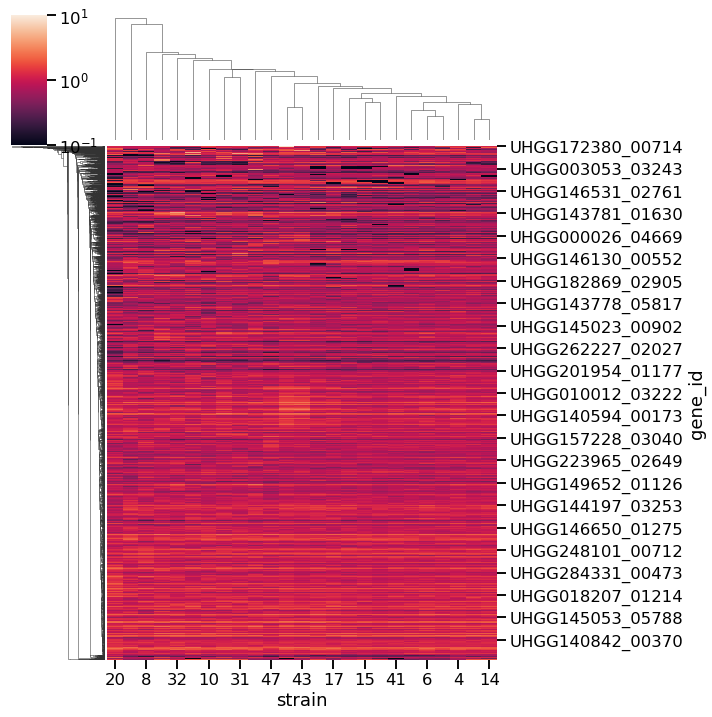

In [44]:
genes_list = idxwhere((high_confidence_hit.mean(1) > 0.8) & (high_confidence_not_hit.mean(1) < 0.05))
if len(genes_list) < 2e4:
    d = strain_depth.loc[genes_list, strain_meta.index]

    sns.clustermap(
        d,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10)
    )

    print(len(genes_list), len(genes_list) - gene_annotation.loc[genes_list]['product'].value_counts()['hypothetical protein'])
    print()
    print(
        gene_annotation
        .loc[genes_list]
        .cog.to_frame()
        .join(cog_meta, on='cog')
        .pathway
        .value_counts()
        .sort_values(ascending=False)
        .head(10)
    )
    print()
    print(
        gene_meta
        .loc[genes_list]
        ['product']
        .value_counts()
        .head(10)
    )
    print()
    print(pd.merge(
        gene_annotation.loc[genes_list].cog.dropna().to_frame(),
        cog_x_category,
        on='cog',
    ).category.value_counts().to_frame().join(cog_category).head(10))
else:
    print("Too many genes to process:", len(genes_list))

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


4689 1355

Non-phosphorylated Entner-Doudoroff pathway    12
Glycolysis                                     10
TCA cycle                                      10
Fatty acid biosynthesis                         9
Cobalamine/B12 biosynthesis                     7
Aromatic amino acid biosynthesis                6
Na+-translocating NADH dehydrogenase            5
Isoleucine, leucine, valine biosynthesis        5
tRNA modification                               5
Histidine biosynthesis                          5
Name: pathway, dtype: int64

hypothetical protein                           3334
Prophage integrase IntA                          16
Tyrosine recombinase XerC                        13
Prophage integrase IntS                           9
Vitamin B12 import ATP-binding protein BtuD       8
putative protein YfcO                             7
DNA-invertase hin                                 6
putative fimbrial-like protein YadK               6
putative fimbrial-like protein YfcR         

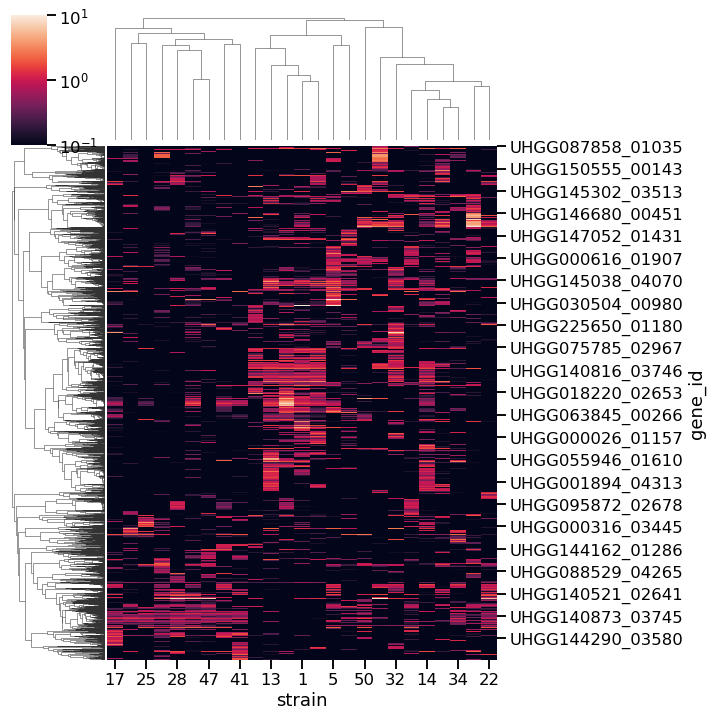

In [45]:
genes_list = idxwhere((high_confidence_hit.mean(1) > 0.05) & (high_confidence_not_hit.mean(1) > 0.2))
if len(genes_list) < 2e4:
    d = strain_depth.loc[genes_list, strain_meta.index]

    sns.clustermap(
        d,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10)
    )

    print(len(genes_list), len(genes_list) - gene_annotation.loc[genes_list]['product'].value_counts()['hypothetical protein'])
    print()
    print(
        gene_annotation
        .loc[genes_list]
        .cog.to_frame()
        .join(cog_meta, on='cog')
        .pathway
        .value_counts()
        .sort_values(ascending=False)
        .head(10)
    )
    print()
    print(
        gene_meta
        .loc[genes_list]
        ['product']
        .value_counts()
        .head(10)
    )
    print()
    print(pd.merge(
        gene_annotation.loc[genes_list].cog.dropna().to_frame(),
        cog_x_category,
        on='cog',
    ).category.value_counts().to_frame().join(cog_category).head(10))
else:
    print("Too many genes to process:", len(genes_list))

# Enrichment Analysis using Depth-only Selection

## Standard Depth Ratio

In [46]:
low_depth_hit = (strain_depth < strain_meta.depth_thresh_low)

/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_7568/3693257472.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  low_depth_hit = (strain_depth < strain_meta.depth_thresh_low)


/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


3403 2242

tRNA modification                           34
Ribosome 50S subunit                        21
TCA cycle                                   17
Fatty acid biosynthesis                     15
Aminoacyl-tRNA synthetases                  15
Glycolysis                                  14
Isoleucine, leucine, valine biosynthesis    13
Pyrimidine salvage                          12
Purine biosynthesis                         12
16S rRNA modification                       12
Name: pathway, dtype: int64

hypothetical protein                           1161
Vitamin B12 import ATP-binding protein BtuD      26
putative protein                                  7
HTH-type transcriptional activator RhaS           5
HTH-type transcriptional regulator HdfR           5
Lon protease                                      4
HTH-type transcriptional repressor NanR           4
L-threonine 3-dehydrogenase                       4
Periplasmic nitrate reductase                     4
Regulator of RpoS     

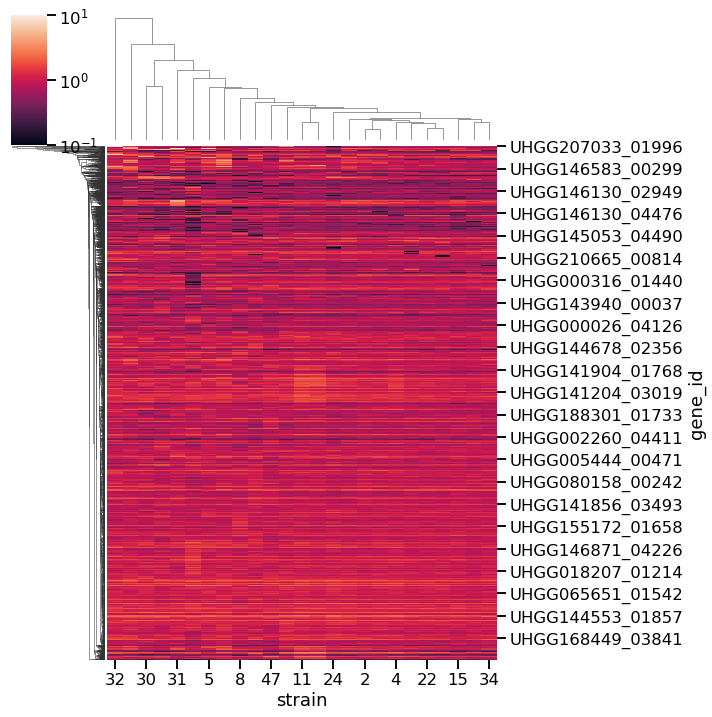

In [47]:
genes_list = idxwhere((depth_hit.mean(1) > 0.8) & (low_depth_hit.mean(1) < 0.05))
if len(genes_list) < 2e4:
    d = strain_depth.loc[genes_list, strain_meta.index]

    sns.clustermap(
        d,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10)
    )

    print(len(genes_list), len(genes_list) - gene_annotation.loc[genes_list]['product'].value_counts()['hypothetical protein'])
    print()
    print(
        gene_annotation
        .loc[genes_list]
        .cog.to_frame()
        .join(cog_meta, on='cog')
        .pathway
        .value_counts()
        .sort_values(ascending=False)
        .head(10)
    )
    print()
    print(
        gene_meta
        .loc[genes_list]
        ['product']
        .value_counts()
        .head(10)
    )
    print()
    print(pd.merge(
        gene_annotation.loc[genes_list].cog.dropna().to_frame(),
        cog_x_category,
        on='cog',
    ).category.value_counts().to_frame().join(cog_category).head(10))
else:
    print("Too many genes to process:", len(genes_list))

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


13017 4495

tRNA modification                              42
Fatty acid biosynthesis                        32
Glycolysis                                     27
Aromatic amino acid biosynthesis               26
TCA cycle                                      24
Heme biosynthesis                              21
Non-phosphorylated Entner-Doudoroff pathway    21
RNA polymerase                                 20
Pyrimidine biosynthesis                        18
Aminoacyl-tRNA synthetases                     18
Name: pathway, dtype: int64

hypothetical protein                                  8522
Tyrosine recombinase XerC                               42
Vitamin B12 import ATP-binding protein BtuD             25
Prophage integrase IntA                                 21
HTH-type transcriptional activator RhaR                 18
Nucleoid occlusion protein                              14
putative protein                                        14
Sensor histidine kinase RcsC                  

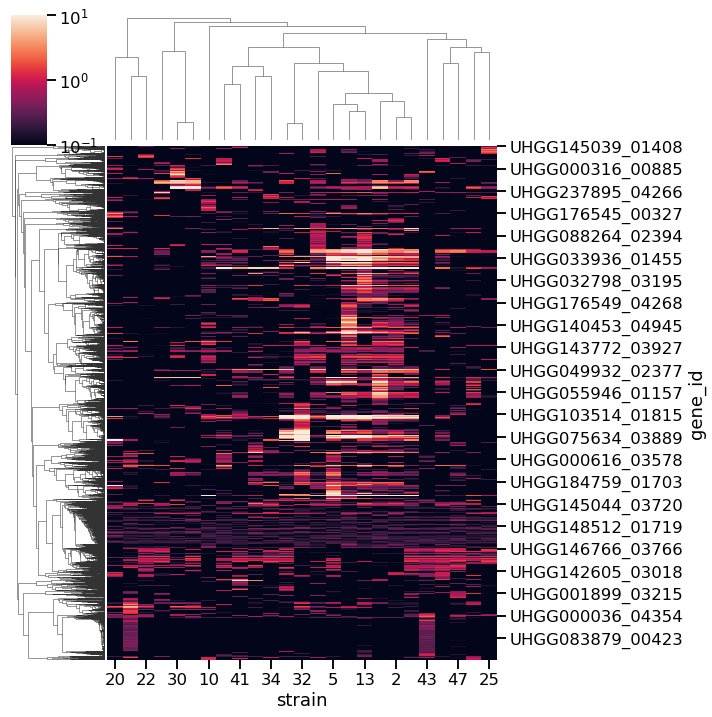

In [48]:
genes_list = idxwhere((depth_hit.mean(1) > 0.05) & (low_depth_hit.mean(1) > 0.2))
if 0 < len(genes_list) < 2e4:
    d = strain_depth.loc[genes_list, strain_meta.index]

    sns.clustermap(
        d,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10)
    )

    print(len(genes_list), len(genes_list) - gene_annotation.loc[genes_list]['product'].value_counts()['hypothetical protein'])
    print()
    print(
        gene_annotation
        .loc[genes_list]
        .cog.to_frame()
        .join(cog_meta, on='cog')
        .pathway
        .value_counts()
        .sort_values(ascending=False)
        .head(10)
    )
    print()
    print(
        gene_meta
        .loc[genes_list]
        ['product']
        .value_counts()
        .head(10)
    )
    print()
    print(pd.merge(
        gene_annotation.loc[genes_list].cog.dropna().to_frame(),
        cog_x_category,
        on='cog',
    ).category.value_counts().to_frame().join(cog_category).head(10))
else:
    print("Too many (or too few) genes to process:", len(genes_list))

# Enrichment Analysis in Reference Genomes

In [49]:
x = reference_gene > 0
y = high_confidence_hit

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=False)
y = y.reindex(_all_genes, fill_value=False)

cdist = pd.DataFrame(sp.spatial.distance.cdist(x.T, y.T, metric='jaccard'), index=x.columns, columns=y.columns)

diff = pd.DataFrame(x[cdist.idxmin()].values * 2 - y[cdist.columns].values * 3, index=x.index, columns=y.columns).replace({-3: 'only_inf', -1: 'shared_genes', 0: 'both_lacking', 2: 'only_ref'})
diff.apply(lambda x: x.value_counts())

strain           1      2      4      5      6      8      10     11     13  \
both_lacking  76080  76861  76141  76182  77302  75271  75393  76523  76156   
shared_genes   3676   3903   3594   3753   3264   3434   3469   3638   3918   
only_inf       1809   1044   1767   1783   1106   2932   2921   1224   1782   
only_ref        604    361    667    451    497    532    386    784    313   

strain           14  ...     25     28     30     31     32     34     41  \
both_lacking  76789  ...  77154  76300  76438  76102  75587  76039  76011   
shared_genes   3878  ...   3143   3473   3556   3847   4085   3709   3536   
only_inf       1114  ...   1473   1861   1687   1762   2181   1992   1828   
only_ref        388  ...    399    535    488    458    316    429    794   

strain           43     47     50  
both_lacking  75080  75441  75933  
shared_genes   3454   3514   3568  
only_inf       3163   2632   1890  
only_ref        472    582    778  

[4 rows x 25 columns]

/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_7568/2571631256.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)


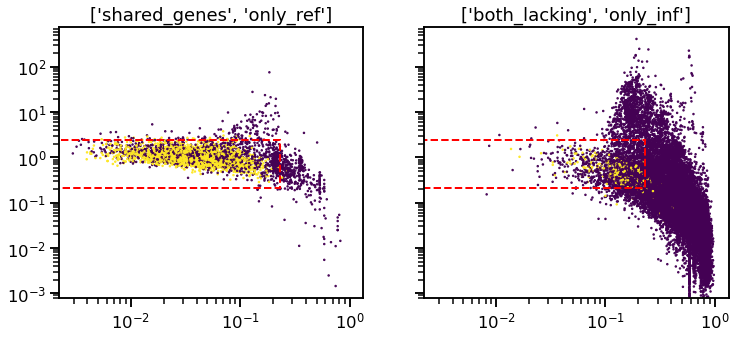

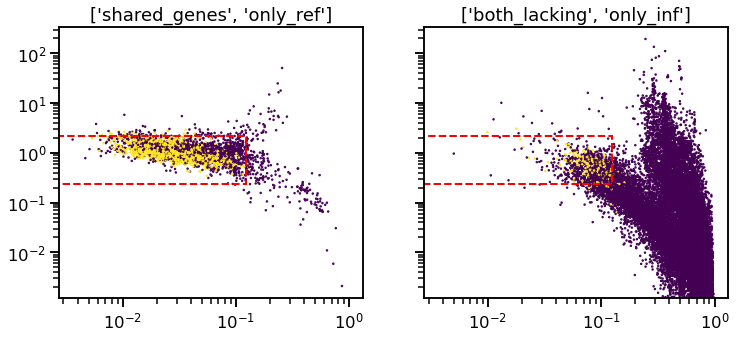

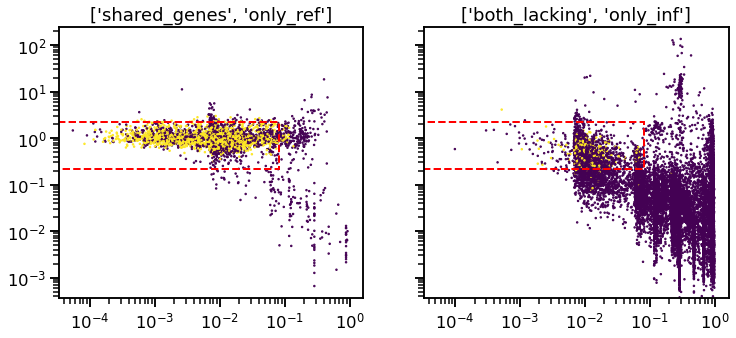

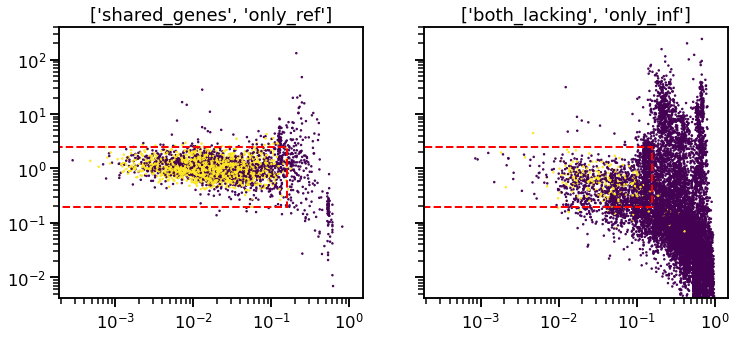

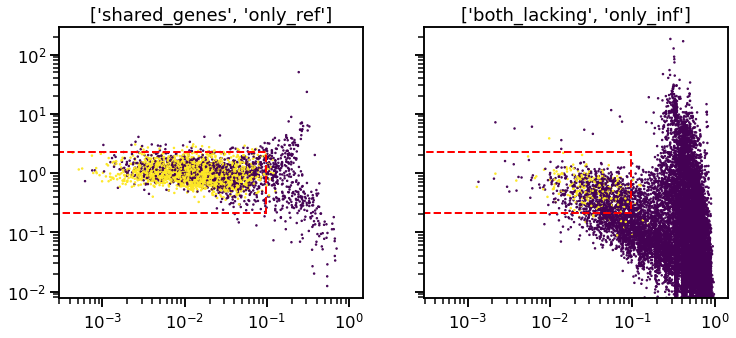

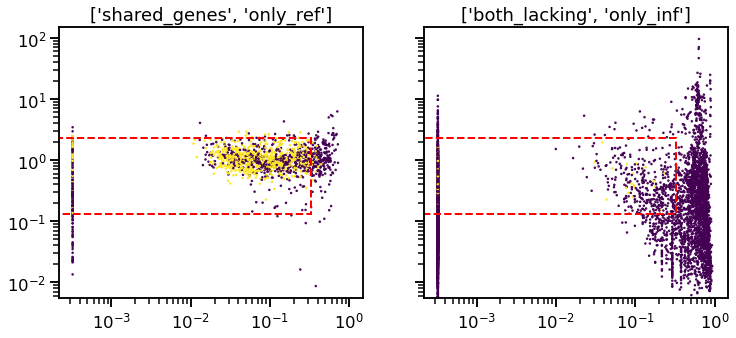

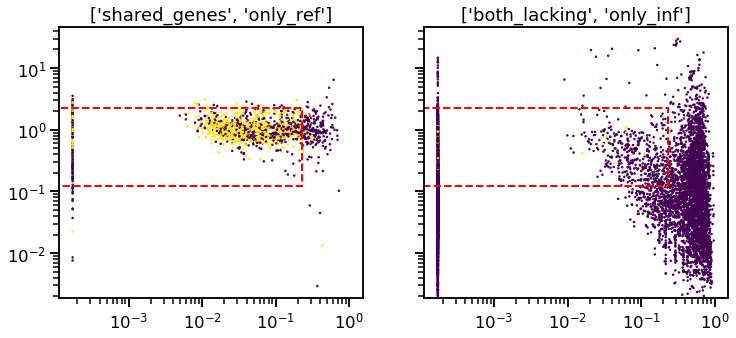

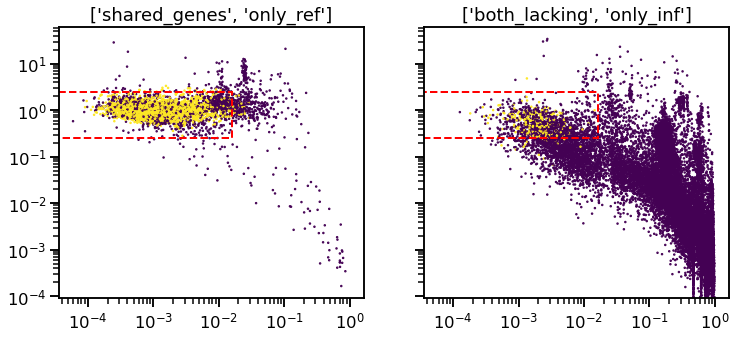

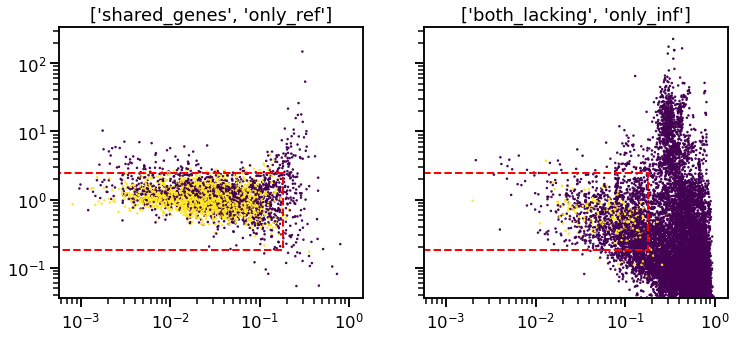

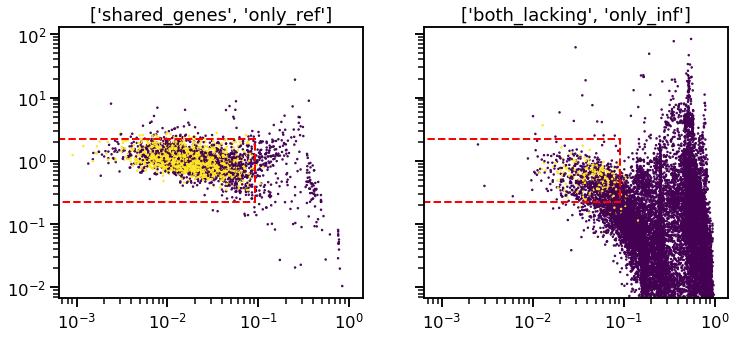

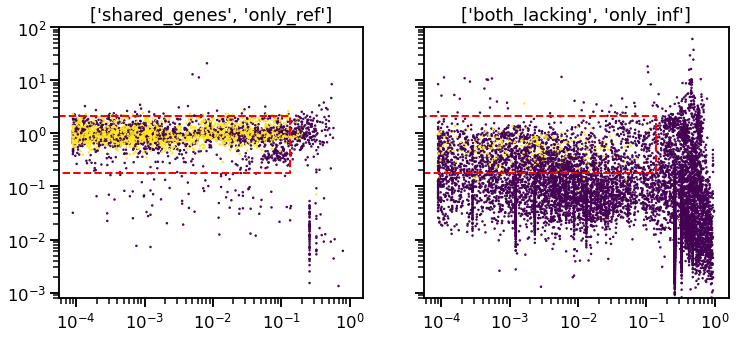

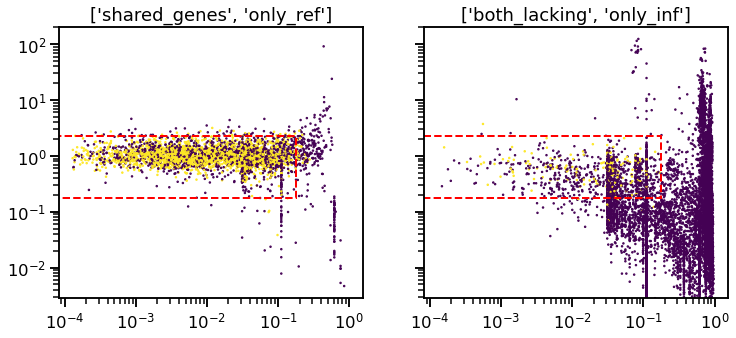

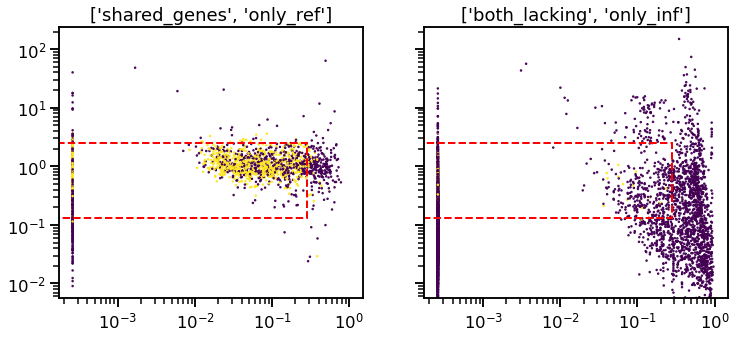

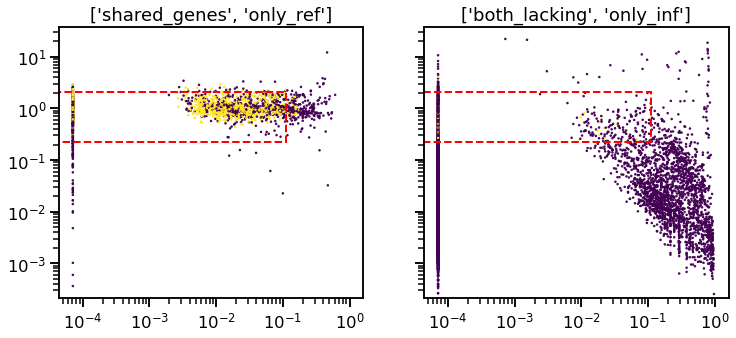

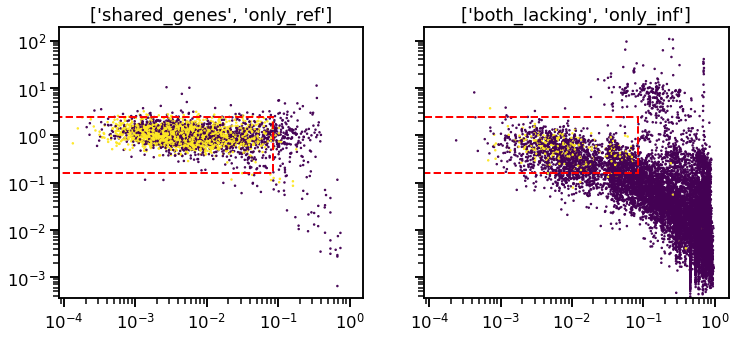

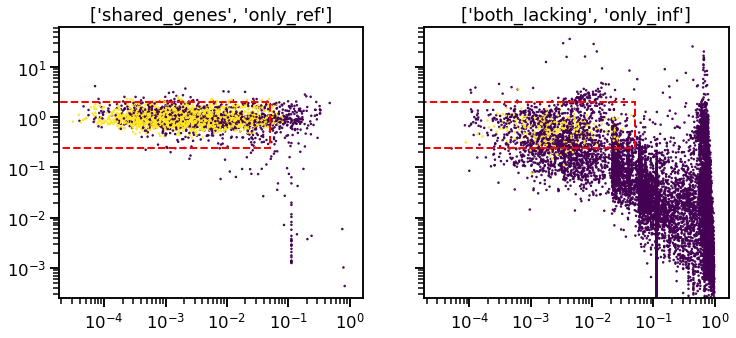

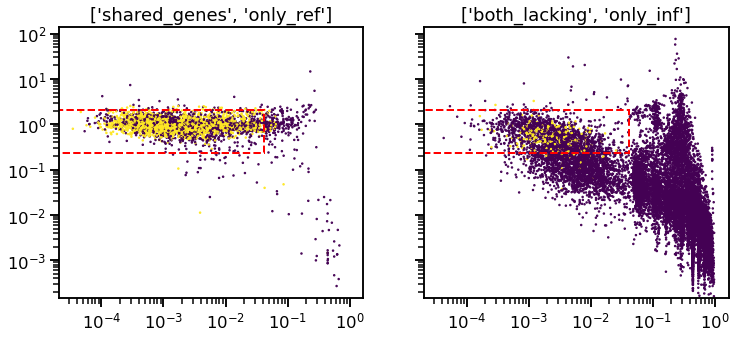

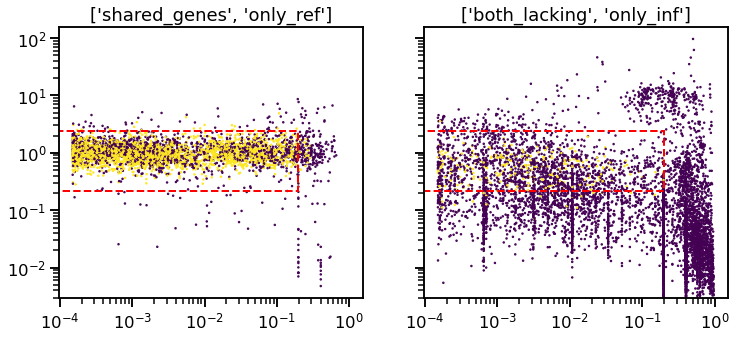

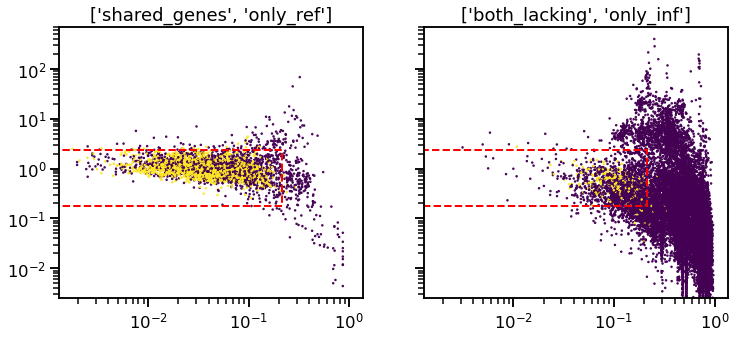

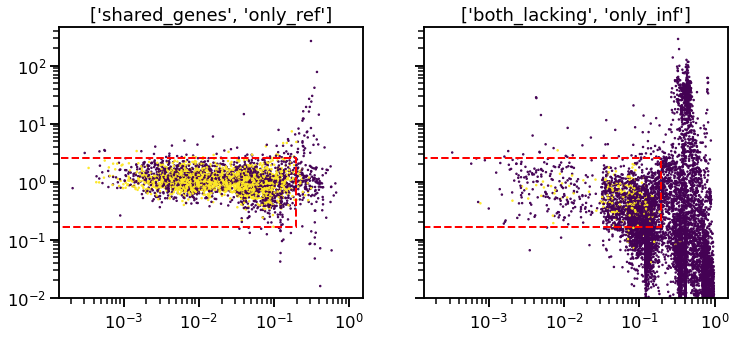

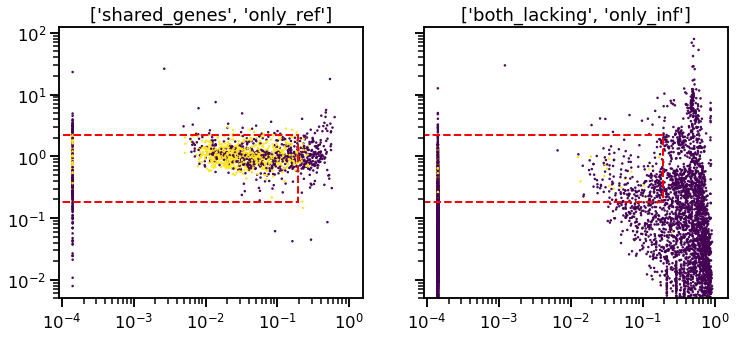

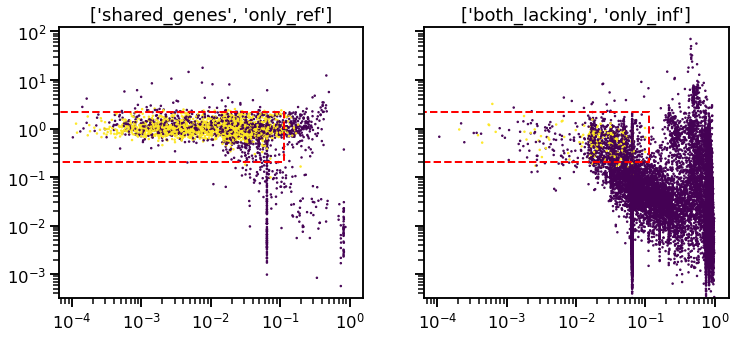

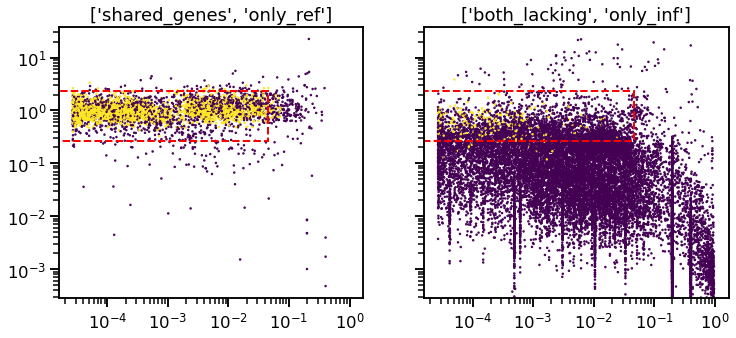

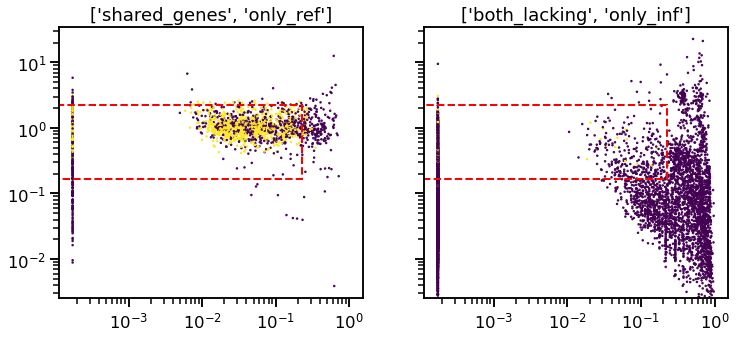

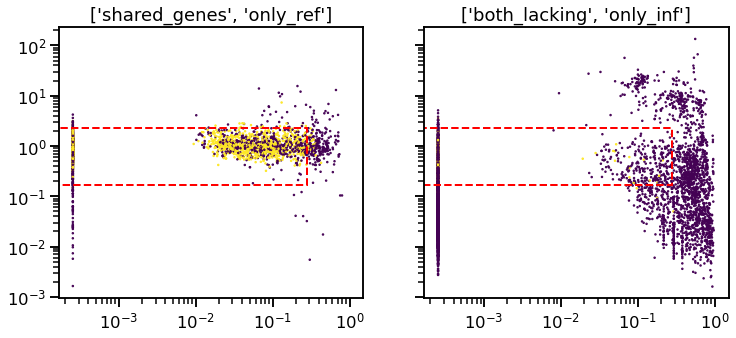

In [50]:
for strain in diff.columns:
    d = pd.DataFrame(dict(
        match_type=diff[strain],
        corr_complement=1 - strain_corr[strain],
        # species_is_top_corr=(strain_by_species_corr.sel(strain=strain).max('species_id') <= strain_by_species_corr.sel(strain=strain, species_id=species_id)).to_series(),
        species_gene=species_corr > species_gene_corr_thresh,
        depth=strain_depth[strain],
    ))

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    match_type_pair_order = [['shared_genes', 'only_ref'], ['both_lacking', 'only_inf']]
    for match_type_pair, ax in zip(match_type_pair_order, axs.flatten()):
        ax.scatter(
            'corr_complement',
            'depth',
            # c='species_is_top_corr',
            c='species_gene',
            data=d[d.match_type.isin(match_type_pair)],
            s=1.0,
            alpha=1.0
        )


    for match_type_pair, ax in zip(match_type_pair_order, axs.flatten()):
        ax.set_title(match_type_pair)
        right = 1 - strain_meta.loc[strain].corr_threshold
        left = 0
        top = strain_meta.depth_thresh_high[strain]
        bottom = strain_meta.depth_thresh_low[strain]
        ax.add_patch(mpl.patches.Rectangle(
            (left, bottom),
            right - left,
            top - bottom,
            linestyle='--',
            facecolor='none',
            edgecolor='red',
            lw=2
        ))
        # ax.axvline(1 - strain_meta.loc[strain].corr_threshold, linestyle='--', color='k', lw=1)
        # ax.axhline(depth_ratio_bound, linestyle='--', color='k', lw=1)
        # ax.axhline(1 / depth_ratio_bound, linestyle='--', color='k', lw=1)
        ax.set_yscale('log')
        ax.set_xscale('log')
        # ax.set_ylim(bottom=0)
        # ax.set_xlim(left=0)

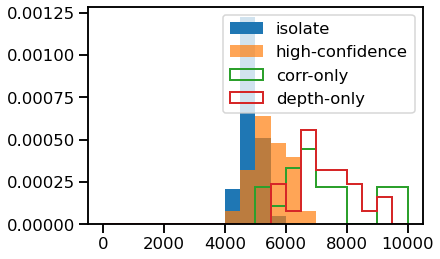

In [51]:
bins = np.linspace(0, 1e4, num=21)

# plt.hist(reference_gene.sum(), density=True, bins=bins)
plt.hist(isolate_gene.sum(), density=True, bins=bins, label='isolate')
plt.hist(high_confidence_hit.sum(), density=True, bins=bins, alpha=0.7, label='high-confidence')
# plt.hist(highest_confidence_hit.sum(), density=True, bins=bins, alpha=0.7, label='highest-confidence')
# plt.hist(medium_confidence_hit.sum(), density=True, alpha=0.5, bins=bins)
plt.hist(corr_hit.sum(), density=True, bins=bins, histtype='step', lw=2, label='corr-only')
plt.hist(depth_hit.sum(), density=True, bins=bins, histtype='step', lw=2, label='depth-only')

plt.legend()
None

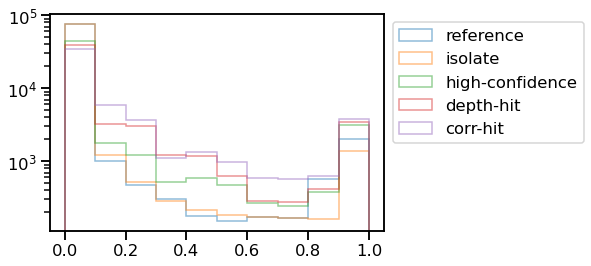

In [52]:
bins = np.linspace(0, 1, num=11)

plt.hist(reference_gene.mean(1), bins=bins, alpha=0.5, label='reference', histtype='step')
plt.hist(isolate_gene.mean(1), bins=bins, alpha=0.5, label='isolate', histtype='step')
# plt.hist(highest_confidence_hit.mean(1), bins=bins, alpha=0.5, label='highest-confidence', histtype='step')
plt.hist(high_confidence_hit.mean(1), bins=bins, alpha=0.5, label='high-confidence', histtype='step')
plt.hist(depth_hit.mean(1), bins=bins, alpha=0.5, label='depth-hit', histtype='step')
plt.hist(corr_hit.mean(1), bins=bins, alpha=0.5, label='corr-hit', histtype='step')


plt.yscale('log')
plt.legend(bbox_to_anchor=(1, 1))

None

In [53]:
reference_gene.shape

(82169, 8288)

In [54]:
(
    len(set(idxwhere((reference_gene > 0).mean(1) > 0.8)) & set(idxwhere(high_confidence_hit.mean(1) > 0.8))),
    len(set(idxwhere((isolate_gene > 0).mean(1) > 0.8)) & set(idxwhere(high_confidence_hit.mean(1) > 0.8))),
)

(2618, 2640)

In [55]:
(
    len(set(idxwhere(high_confidence_hit.mean(1) > 0.8)) - set(idxwhere((reference_gene > 0).mean(1) > 0.8))),
    len(set(idxwhere(high_confidence_hit.mean(1) > 0.8)) - set(idxwhere((isolate_gene > 0).mean(1) > 0.8))),
)

(841, 819)

In [56]:
(
    len(set(idxwhere((reference_gene > 0).mean(1) > 0.8)) - set(idxwhere(high_confidence_hit.mean(1) > 0.8))),
    len(set(idxwhere((isolate_gene > 0).mean(1) > 0.8)) - set(idxwhere(high_confidence_hit.mean(1) > 0.8))),
)

(323, 466)

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.8463915336081622, 0.0)


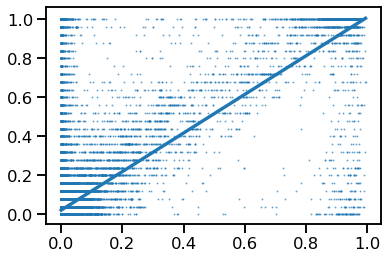

In [57]:
x = (reference_gene > 0).mean(1)
y = high_confidence_hit.mean(1)

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=0)
y = y.reindex(_all_genes, fill_value=0)

sns.regplot(x, y, scatter_kws=dict(s=1, alpha=0.5))
print(sp.stats.pearsonr(x, y))

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.8374045754493071, 0.0)


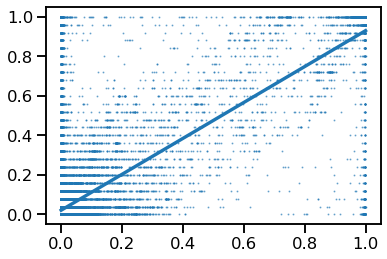

In [58]:
x = (isolate_gene > 0).mean(1)
y = high_confidence_hit.mean(1)

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=0)
y = y.reindex(_all_genes, fill_value=0)

sns.regplot(x, y, scatter_kws=dict(s=1, alpha=0.5))
print(sp.stats.pearsonr(x, y))

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.7471741559467537, 0.0)


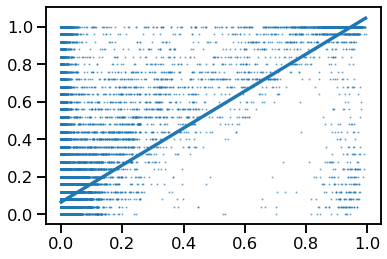

In [59]:
x = (reference_gene > 0).mean(1)
y = corr_hit.mean(1)

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=0)
y = y.reindex(_all_genes, fill_value=0)


sns.regplot(x, y, scatter_kws=dict(s=1, alpha=0.5))
print(sp.stats.pearsonr(x, y))

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.8274938335224816, 0.0)


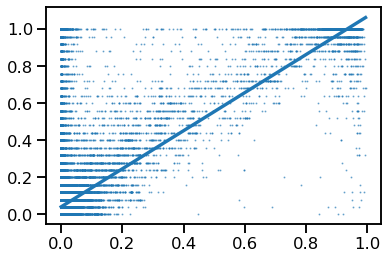

In [60]:
x = (reference_gene > 0).mean(1)
y = depth_hit.mean(1)

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=0)
y = y.reindex(_all_genes, fill_value=0)


sns.regplot(x, y, scatter_kws=dict(s=1, alpha=0.5))
print(sp.stats.pearsonr(x, y))

In [61]:
x = (reference_gene > 0)
y = high_confidence_hit

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=False)
y = y.reindex(_all_genes, fill_value=False)

jac_cdist_inf = pd.DataFrame(sp.spatial.distance.cdist(x.T, y.T, metric='jaccard'), index=x.columns, columns=y.columns)

In [62]:
x = (reference_gene > 0)
y = corr_hit

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=False)
y = y.reindex(_all_genes, fill_value=False)

jac_cdist_inf2 = pd.DataFrame(sp.spatial.distance.cdist(x.T, y.T, metric='jaccard'), index=x.columns, columns=y.columns)

In [63]:
x = (reference_gene > 0)
y = depth_hit

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=False)
y = y.reindex(_all_genes, fill_value=False)

jac_cdist_inf3 = pd.DataFrame(sp.spatial.distance.cdist(x.T, y.T, metric='jaccard'), index=x.columns, columns=y.columns)

In [64]:
x = (reference_gene > 0)

u, v = x[jac_cdist_inf.idxmin().to_list()], x.drop(jac_cdist_inf.idxmin().to_list(), axis='columns')

jac_cdist_ref = pd.DataFrame(sp.spatial.distance.cdist(u.T, v.T, metric='jaccard'), index=u.columns, columns=v.columns).T

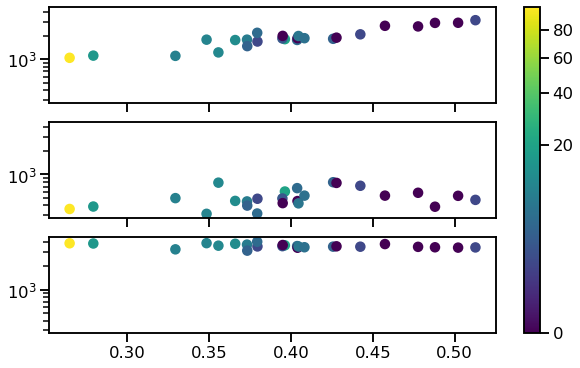

In [65]:
d = strain_meta.join(diff.apply(lambda x: x.value_counts()).T).assign(**dict(
    conf_hit_min_dist=jac_cdist_inf.min(),
    corr_hit_min_dist=jac_cdist_inf2.min(),
    depth_hit_min_dist=jac_cdist_inf3.min(),
))

# d = strain_meta.join(diff.apply(lambda x: x.value_counts()).T)

fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(10, 6))

axs[0].set_yscale('log')

mappable = axs[0].scatter('conf_hit_min_dist', 'only_inf', data=d, c='num_samples', norm=mpl.colors.PowerNorm(1/3))
mappable = axs[1].scatter('conf_hit_min_dist', 'only_ref', data=d, c='num_samples', norm=mpl.colors.PowerNorm(1/3))
mappable = axs[2].scatter('conf_hit_min_dist', 'shared_genes', data=d, c='num_samples', norm=mpl.colors.PowerNorm(1/3))

plt.colorbar(mappable, ax=axs)
# axs[1].set_xscale('log')

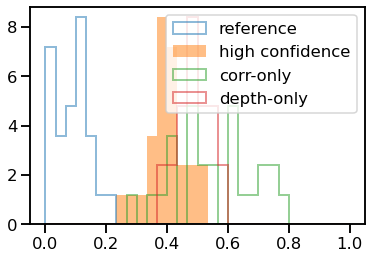

In [66]:
bins = np.linspace(0, 1, num=31)
plt.hist(jac_cdist_ref.min(), bins=bins, alpha=0.5, label='reference', density=True, histtype='step', lw=2)
plt.hist(jac_cdist_inf.min(), bins=bins, alpha=0.5, label='high confidence', density=True, histtype='stepfilled', lw=2)
plt.hist(jac_cdist_inf2.min(), bins=bins, alpha=0.5, label='corr-only', density=True, histtype='step', lw=2)
plt.hist(jac_cdist_inf3.min(), bins=bins, alpha=0.5, label='depth-only', density=True, histtype='step', lw=2)
plt.legend()

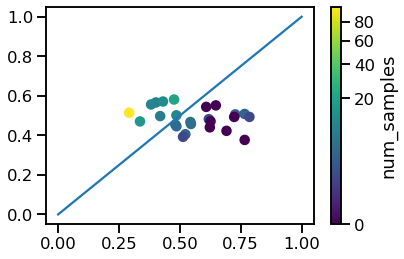

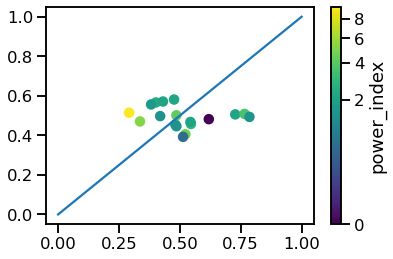

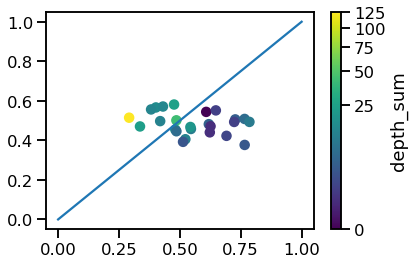

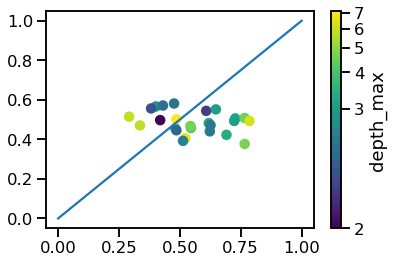

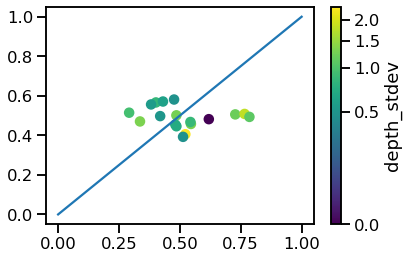

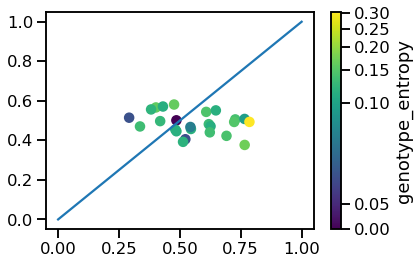

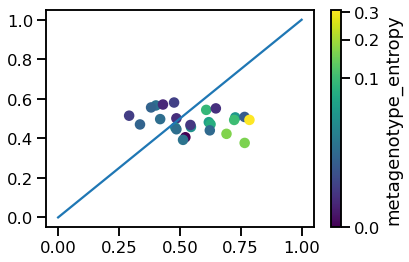

In [67]:
d = pd.DataFrame(dict(
    conf_hit_min_dist=jac_cdist_inf.min(),
    depth_hit_min_dist=jac_cdist_inf3.min(),
    corr_hit_min_dist=jac_cdist_inf2.min(),
    # med_conf_hit_min_dist=jac_cdist_inf4.min(),
)).join(strain_meta)

for c in ['num_samples', 'power_index', 'depth_sum', 'depth_max', 'depth_stdev', 'genotype_entropy', 'metagenotype_entropy']:
    plt.figure()
    plt.scatter('corr_hit_min_dist', 'depth_hit_min_dist', data=d, c=c, norm=mpl.colors.PowerNorm(1/3))
    plt.colorbar(label=c)
    plt.plot([0, 1.0], [0, 1.0])

SpearmanrResult(correlation=-0.8280089040743492, pvalue=3.24888607765384e-07)

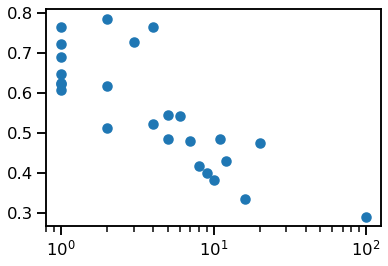

In [68]:
d = pd.DataFrame(dict(
    conf_hit_min_dist=jac_cdist_inf.min(),
    depth_hit_min_dist=jac_cdist_inf3.min(),
    corr_hit_min_dist=jac_cdist_inf2.min(),
    # med_conf_hit_min_dist=jac_cdist_inf4.min(),
)).join(strain_meta)

    
plt.figure()
plt.scatter(d['num_samples'], d['corr_hit_min_dist'])
plt.xscale('log')
sp.stats.spearmanr(d['num_samples'], d['corr_hit_min_dist'])

SpearmanrResult(correlation=0.43483119221958066, pvalue=0.029837657067997212)

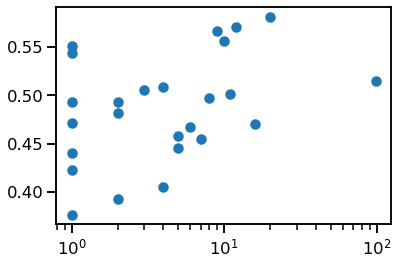

In [69]:
d = pd.DataFrame(dict(
    conf_hit_min_dist=jac_cdist_inf.min(),
    depth_hit_min_dist=jac_cdist_inf3.min(),
    corr_hit_min_dist=jac_cdist_inf2.min(),
    # med_conf_hit_min_dist=jac_cdist_inf4.min(),
)).join(strain_meta)

    
plt.figure()
plt.scatter(d['num_samples'], d['depth_hit_min_dist'])
plt.xscale('log')
sp.stats.spearmanr(d['num_samples'], d['depth_hit_min_dist'])

SpearmanrResult(correlation=-0.7626090470529621, pvalue=9.352388445904989e-06)

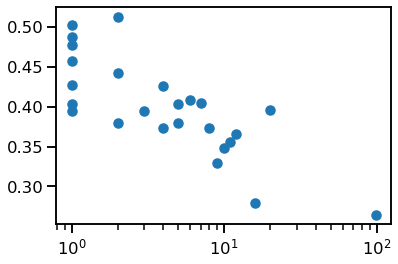

In [70]:
d = pd.DataFrame(dict(
    conf_hit_min_dist=jac_cdist_inf.min(),
    depth_hit_min_dist=jac_cdist_inf3.min(),
    corr_hit_min_dist=jac_cdist_inf2.min(),
    # med_conf_hit_min_dist=jac_cdist_inf4.min(),
)).join(strain_meta)

    
plt.figure()
plt.scatter(d['num_samples'], d['conf_hit_min_dist'])
plt.xscale('log')
sp.stats.spearmanr(d['num_samples'], d['conf_hit_min_dist'])

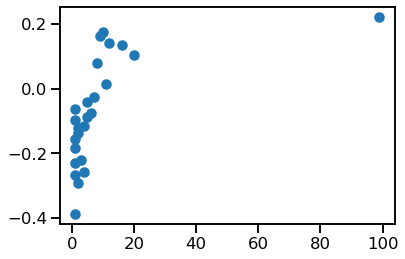

In [71]:
d = pd.DataFrame(dict(
    conf_hit_min_dist=jac_cdist_inf.min(),
    depth_hit_min_dist=jac_cdist_inf3.min(),
    corr_hit_min_dist=jac_cdist_inf2.min(),
    # med_conf_hit_min_dist=jac_cdist_inf4.min(),
)).join(strain_meta)

plt.scatter(d.num_samples, d.depth_hit_min_dist - d.corr_hit_min_dist)

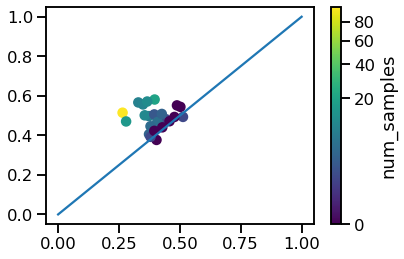

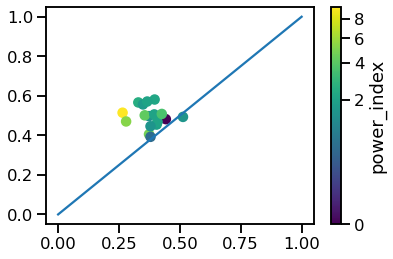

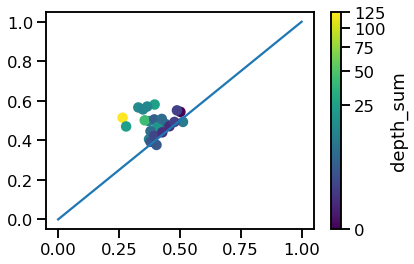

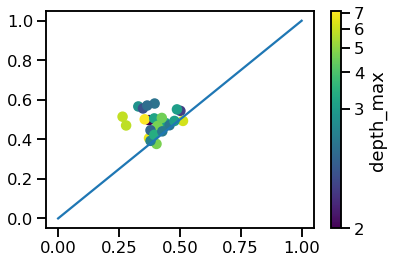

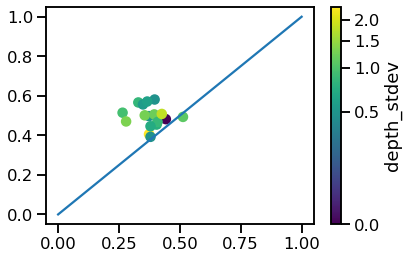

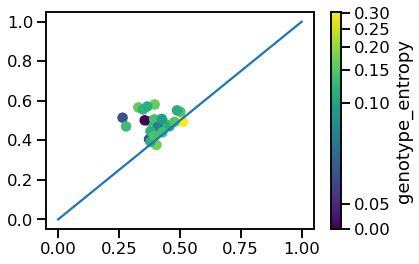

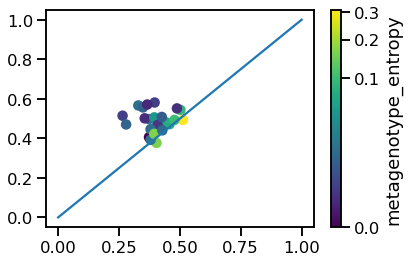

In [72]:
d = pd.DataFrame(dict(
    conf_hit_min_dist=jac_cdist_inf.min(),
    depth_hit_min_dist=jac_cdist_inf3.min(),
    corr_hit_min_dist=jac_cdist_inf2.min(),
    # med_conf_hit_min_dist=jac_cdist_inf4.min(),
)).join(strain_meta)

for c in ['num_samples', 'power_index', 'depth_sum', 'depth_max', 'depth_stdev', 'genotype_entropy', 'metagenotype_entropy']:
    plt.figure()
    plt.scatter('conf_hit_min_dist', 'depth_hit_min_dist', data=d, c=c, norm=mpl.colors.PowerNorm(1/3))
    plt.colorbar(label=c)
    plt.plot([0, 1.0], [0, 1.0])

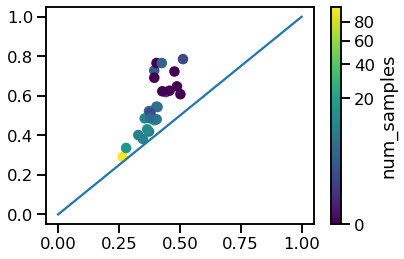

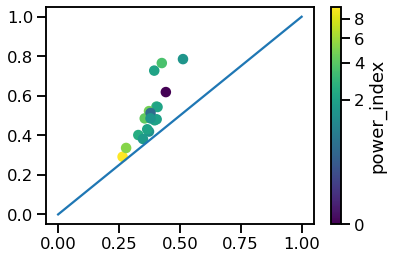

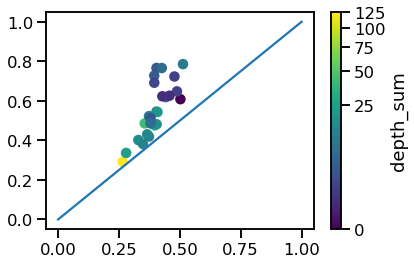

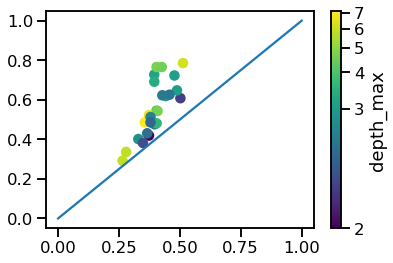

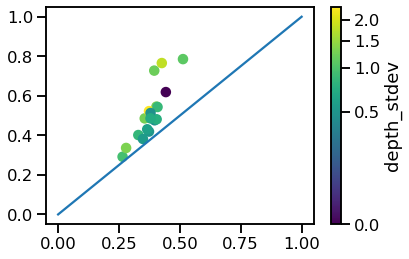

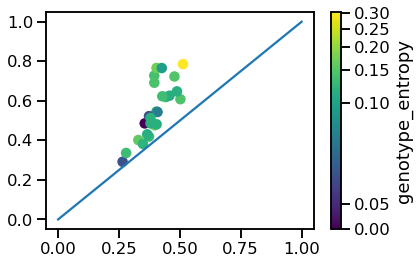

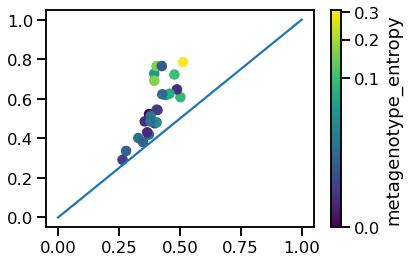

In [73]:
d = pd.DataFrame(dict(
    conf_hit_min_dist=jac_cdist_inf.min(),
    depth_hit_min_dist=jac_cdist_inf3.min(),
    corr_hit_min_dist=jac_cdist_inf2.min(),
    # med_conf_hit_min_dist=jac_cdist_inf4.min(),
)).join(strain_meta)

for c in ['num_samples', 'power_index', 'depth_sum', 'depth_max', 'depth_stdev', 'genotype_entropy', 'metagenotype_entropy']:
    plt.figure()
    plt.scatter('conf_hit_min_dist', 'corr_hit_min_dist', data=d, c=c, norm=mpl.colors.PowerNorm(1/3))
    plt.colorbar(label=c)
    plt.plot([0, 1.0], [0, 1.0])

In [74]:
x = reference_gene > 0
y = depth_hit

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=False)
y = y.reindex(_all_genes, fill_value=False)

cdist = pd.DataFrame(sp.spatial.distance.cdist(x.T, y.T, metric='jaccard'), index=x.columns, columns=y.columns)

diff2 = pd.DataFrame(x[cdist.idxmin()].values * 2 - y[cdist.columns].values * 3, index=x.index, columns=y.columns).replace({-3: 'only_inf', -1: 'shared_genes', 0: 'both_lacking', 2: 'only_ref'})
diff2.apply(lambda x: x.value_counts())

strain           1      2      4      5      6      8      10     11     13  \
both_lacking  72481  73850  75157  74393  73409  73774  73981  74192  73121   
only_inf       5328   4055   2751   3572   4409   3882   4330   3555   4817   
only_ref        303    226    457    295    553    685    186    444    217   
shared_genes   4057   4038   3804   3909   3798   3828   3672   3978   4014   

strain           14  ...     25     28     30     31     32     34     41  \
both_lacking  74100  ...  76493  75155  75982  72667  74500  75388  74532   
only_inf       3637  ...   2134   2863   2143   5128   3268   2643   3307   
only_ref        158  ...    168    417    285    299    152    224    575   
shared_genes   4274  ...   3374   3734   3759   4075   4249   3914   3755   

strain           43     47     50  
both_lacking  74906  74824  75426  
only_inf       3270   3249   2397  
only_ref        313    373    573  
shared_genes   3680   3723   3773  

[4 rows x 25 columns]

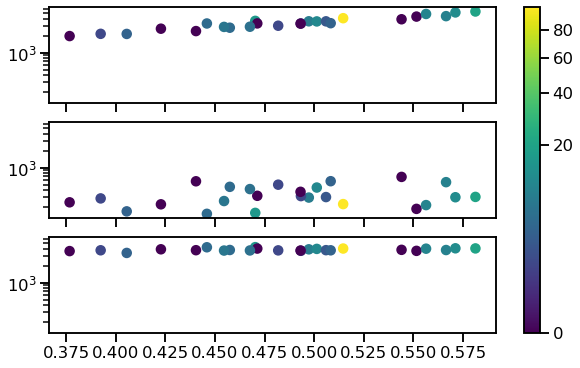

In [75]:
d = strain_meta.join(diff2.apply(lambda x: x.value_counts()).T).assign(**dict(
    conf_hit_min_dist=jac_cdist_inf.min(),
    corr_hit_min_dist=jac_cdist_inf2.min(),
    depth_hit_min_dist=jac_cdist_inf3.min(),
))

# d = strain_meta.join(diff.apply(lambda x: x.value_counts()).T)

fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(10, 6))

axs[0].set_yscale('log')

mappable = axs[0].scatter('depth_hit_min_dist', 'only_inf', data=d, c='num_samples', norm=mpl.colors.PowerNorm(1/3))
mappable = axs[1].scatter('depth_hit_min_dist', 'only_ref', data=d, c='num_samples', norm=mpl.colors.PowerNorm(1/3))
mappable = axs[2].scatter('depth_hit_min_dist', 'shared_genes', data=d, c='num_samples', norm=mpl.colors.PowerNorm(1/3))

plt.colorbar(mappable, ax=axs)
# axs[1].set_xscale('log')